# Image Segmentation - Pytorch

## 1. Colab İndirmeleri

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

## Veri Setini İndirme

Veri setini oluşturan :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset

Bu bölümde U-Net mimarisi kullanılacaktır. U-Net'teki önemli bir geliştirme ağın bağlam bilgisini daha yüksek çözünürlüklü katmanlara yaymasına izin veren çok sayıda özellik kanalı olmasıdır. Sonuç olarak, genişleyen yol, daralma yoluna simetriktir ve u-şekilli bir mimari sağlar. Ağ, tamamen bağlantılı katmanlar olmadan her evrişimin yalnızca geçerli kısmını kullanır. Görüntünün kenarlık bölgesindeki pikselleri tahmin etmek için, eksik bağlam giriş görüntüsünün aynalanmasıyla tahmin edilir. Bu yerleştirme stratejisi, ağı büyük görüntülere uygulamak için önemlidir, çünkü aksi takdirde çözünürlük GPU belleği ile sınırlı olacaktır.

In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 10.37 MiB/s, done.
Resolving deltas: 100% (3/3), done.


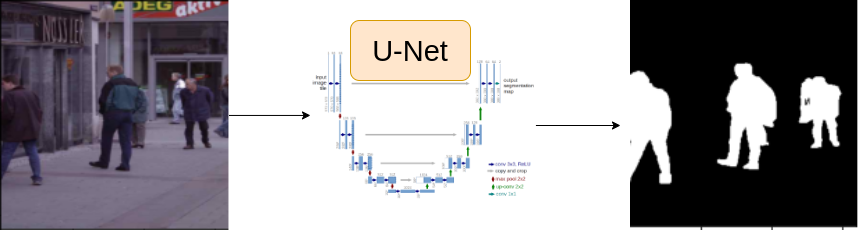

## Importlar

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

## 2. Configuration

Daha sonra kullanacağımız ayarları teker teker değiştirmemek için başta tanımlayıp ayarlarla oynama sürecimizi kolaylaştırıyoruz.

In [5]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content/'

DEVICE='cuda'

EPOCHS=25
BATCH_SIZE=16
LR=0.003
IMAGE_SIZE=320

ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'

Burada csv dosyasını okuyup örneklerin neler olduğuna ve neye benzediğine bakıyoruz. Böylece yaptığımız işi daha iyi anlayabiliriz.

In [6]:
df=pd.read_csv(CSV_FILE)

csv dosyasında fotoğrafların yolları olduğu için bunu opencv kullanarak fotoğrafları görüntülemede kullanıyoruz. 

In [7]:
row=df.iloc[4]

image_path=row.images
mask_path=row.masks

image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

Maskeleme içim IMREAD_GRAYSCALE kullanıyoruz çünkü bu fotoğraflar önceki fotoğraf çeşitinden farklı...

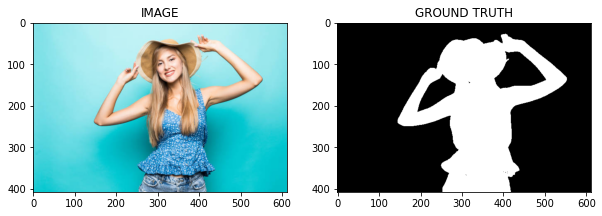

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

Üstte gördüğümüz gibi mask ve normal fotoğraflarımız birbirinden farklı.

Burada anlayacağımız, fotoğrafların neleri simgelediği ve bunu kullanmak için nasıl bir yol izleyebileceğimizdir.

In [9]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

## 3. Augmentation

Albumentation Dökümantasyonu : https://albumentations.ai/docs/

Augmentation'dan kısaca bahsetmek gerekirse bu terim eğitim veya test için kullanılabilmekte olup resimleri döndürme, kesme, tekrardan şekillendirme işlemleridir.

In [10]:
import albumentations as A

Augmentation için kendi fonksiyonlarımızı oluşturuyoruz...

In [11]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
  ])

def get_validate_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ])


## 4. Custom Veri Seti 

Kendimize train ve validation veri setlerini oluşturmak için bir class tanımlıyoruz...

In [12]:
from torch.utils.data import Dataset

Buradaki işlemlerimiz 2. kısımdakilerle aynı işlemlerdir. 

Yaptığımız işlere bir class ile tekrar tekrar çağırabilme özelliği kazandırmak istiyoruz.

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask=np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']

        ##(h,w,c)--> (c,h,w)
    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)

    return image,mask

Veri setlerimizi trainset ve validset olarak bölüyor ve uzunluklarına bakıyoruz...

In [14]:
trainset=SegmentationDataset(train_df,get_train_augs())
validset=SegmentationDataset(valid_df,get_validate_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


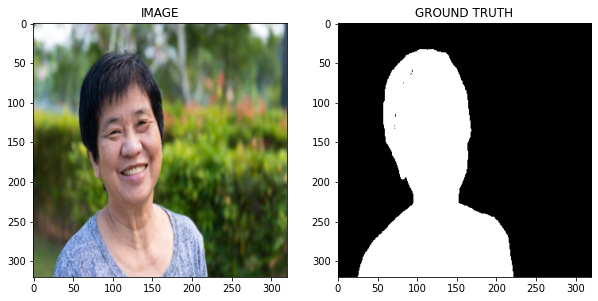

In [16]:
idx=3

image,mask=trainset[idx]
helper.show_image(image,mask)

## 5. Veri Setini Batchlere Bölme

In [17]:
from torch.utils.data import DataLoader

DataLoader kullanarak veri setini BATCH_SIZE'ımıza göre batchlere ayırıyoruz

In [18]:
trainLoader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validLoader=DataLoader(validset,batch_size=BATCH_SIZE)

In [19]:
print(f'Trainloader batch size: {len(trainLoader)}')
print(f'Validloader batch size: {len(validLoader)}')

Trainloader batch size: 15
Validloader batch size: 4


In [20]:
for image,mask in trainLoader:
  break
print(f'img shape: {image.shape}')
print(f'mask shape: {mask.shape}')

img shape: torch.Size([16, 3, 320, 320])
mask shape: torch.Size([16, 1, 320, 320])


## 6. Model

segmentation_models_pytorch Dökümantasyonu : https://smp.readthedocs.io/en/latest/

Kullandığımız modele, parametrelerine ve açıklamalara üstteki linkten ulaşabilirsiniz.

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

Buradaki class'ta ise configuration bölümünde belirlediğimiz parametreleri giriyoruz ve mimarinin kayıp fonksiyonlarını belirliyoruz.

In [22]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )
  def forward(self,images,masks=None):
    logits=self.arc(images)

    if masks!=None:
      loss1=DiceLoss(mode='binary')(logits,masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss1+loss2
    return logits

Eğer bilgisayarınızda 'cuda' kurulu ise GPU'nuzu kullanarak eğitim sürecinizi yapabilirsiniz.

Alttaki kod parçasında .to(DEVICE) kısmı bunun içindir...

In [23]:
model=SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

## 7. Train and Validation Fonksiyonu 

Eğitim döngüsünde işler daha basite indirgensin diye eğitim ve eval için kullanılacak fonksiyonu şimdiden yazıyoruz.

Kayıplarımızı belirlemek için değeri ilk başta sıfırlıyoruz. Daha sonra fotoğrafları gradiyent olmadan sokup kayıpımızı hesaplıyoruz...

In [24]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss=0.0
  for images ,masks in tqdm(data_loader):
    images=images.to(DEVICE)
    masks=masks.to(DEVICE)

    optimizer.zero_grad()

    logits,loss=model(images,masks)
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()

    return total_loss/len(data_loader)

Burada ise eğitim kısmına benzer bir kayıp hesabı yapıyoruz fakat buradaki önemli işlerden birisi kaybımızı direkt ele alıyor oluşumuz ve no_grad'ın yokluğudur.

In [29]:
def eval_fn(data_loader,model):
  model.eval()
  total_loss=0.0

  with torch.no_grad():
    for images ,masks in tqdm(data_loader):
      images=images.to(DEVICE)
      masks=masks.to(DEVICE)

      logits,loss=model(images,masks)
      total_loss+=loss.item()

  return total_loss/len(data_loader)


## 8. Eğitim

In [30]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

Adam optimizörünü kullanıyoruz ve eğitim döngümüzü kuruyoruz. 

Burada en iyi modeli kaydetmek ve kaybımızı her adımda görmek istiyoruz...

In [31]:
best_val_loss=np.Inf

for i in range(EPOCHS):
  train_loss=train_fn(trainLoader,model,optimizer)
  valid_loss=eval_fn(validLoader,model)

  if valid_loss< best_val_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print('Model Saved')
    best_valid_loss=valid_loss
  print(f'Epochs:{i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}')

  

100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


Model Saved
Epochs:1 Train_loss: 0.07692410151163737 Valid_loss: 2.1787489652633667


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Model Saved
Epochs:2 Train_loss: 0.05917602777481079 Valid_loss: 1.5275397896766663


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Model Saved
Epochs:3 Train_loss: 0.05018353462219238 Valid_loss: 3.054076611995697


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Model Saved
Epochs:4 Train_loss: 0.044290351867675784 Valid_loss: 8.38938820362091


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Model Saved
Epochs:5 Train_loss: 0.03997751871744792 Valid_loss: 7.4668275117874146


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Model Saved
Epochs:6 Train_loss: 0.03320764501889547 Valid_loss: 6.850775718688965


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Model Saved
Epochs:7 Train_loss: 0.039291787147521975 Valid_loss: 13.885995626449585


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Model Saved
Epochs:8 Train_loss: 0.030167428652445476 Valid_loss: 6.467611908912659


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Model Saved
Epochs:9 Train_loss: 0.03177298108736674 Valid_loss: 6.138451457023621


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Model Saved
Epochs:10 Train_loss: 0.026311161120732625 Valid_loss: 1.8257036209106445


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Model Saved
Epochs:11 Train_loss: 0.019118630886077882 Valid_loss: 0.6529152989387512


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Model Saved
Epochs:12 Train_loss: 0.0279298464457194 Valid_loss: 0.497649185359478


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Model Saved
Epochs:13 Train_loss: 0.037879014015197755 Valid_loss: 0.7079750299453735


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Model Saved
Epochs:14 Train_loss: 0.028315865993499757 Valid_loss: 1.619621902704239


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Model Saved
Epochs:15 Train_loss: 0.021690543492635092 Valid_loss: 2.0608765184879303


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Model Saved
Epochs:16 Train_loss: 0.03139914075533549 Valid_loss: 1.3721124529838562


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Model Saved
Epochs:17 Train_loss: 0.02541269063949585 Valid_loss: 0.8989384025335312


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


Model Saved
Epochs:18 Train_loss: 0.023441267013549805 Valid_loss: 0.6710499376058578


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Model Saved
Epochs:19 Train_loss: 0.017515834172566733 Valid_loss: 0.5937512144446373


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Model Saved
Epochs:20 Train_loss: 0.02813496390978495 Valid_loss: 0.5972602441906929


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Model Saved
Epochs:21 Train_loss: 0.022686878840128582 Valid_loss: 0.5125713422894478


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Model Saved
Epochs:22 Train_loss: 0.018983322381973266 Valid_loss: 0.4216138944029808


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Model Saved
Epochs:23 Train_loss: 0.020484660069147745 Valid_loss: 0.38020647317171097


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Model Saved
Epochs:24 Train_loss: 0.02497301499048869 Valid_loss: 0.3938998505473137


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Model Saved
Epochs:25 Train_loss: 0.021723981698354086 Valid_loss: 0.42292989045381546


## 9. Sonuç

Sonuç olarak eğitimimizden çıkan sonuçlar alttaki gibidir...

In [32]:
idx=20

model.load_state_dict(torch.load('/content/best_model.pt'))

image,mask=validset[idx]

logits_mask=model(image.to(DEVICE).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask > 0.5)*1.0

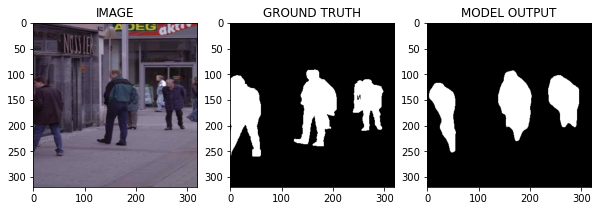

In [33]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))